In [30]:
# Работа с данными
import pandas as pd
import numpy as np
import time

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
import missingno as msno

# Разбиение на train и test, кросс-валидацияб подбор гиперпараметров
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid

# Препроцессинг и пайплайны
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbLearnPipeline
from imblearn.over_sampling import SMOTE


# Модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Метрики и оценки
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, f1_score, average_precision_score, ConfusionMatrixDisplay
import shap

import mlflow
import mlflow.sklearn

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
shap.initjs()
mlflow.set_tracking_uri("http://localhost:5000")
print("Все бибилотеки успешно подключены ☑️")

Все бибилотеки успешно подключены ☑️


##### Загрузка и обзор датасета

In [3]:
credit_data = pd.read_csv(r"E:\projects\Проекты по DS\data\creditcard.csv")
print(credit_data.shape)

(284807, 31)


In [3]:
print(credit_data.head(5))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

In [8]:
print(credit_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
print(credit_data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

### Разведывательеный анализ данных (EDA)  

посмотрим на распределение таргета и найдём центральные тенденции

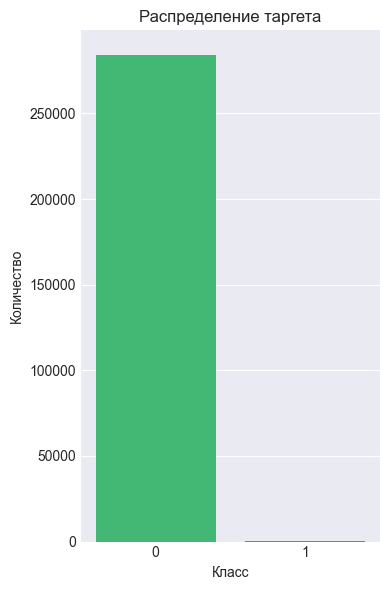

In [9]:
plt.figure(figsize=(4, 6))
sns.countplot(data=credit_data, x='Class', palette=['#2ecc71', '#e74c3c'])
plt.title('Распределение таргета')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.tight_layout()
plt.legend()
plt.show()

In [4]:
fraud_count = credit_data['Class'].value_counts()
fraud_percentage = credit_data['Class'].value_counts(normalize=True) * 100

print(f'Законные трагзакции(0): {fraud_count[0]} ({fraud_percentage[0]})')
print(f'Мошеннические транзакции(2): {fraud_count[1]} ({fraud_percentage[1]})')

Законные трагзакции(0): 284315 (99.82725143693798)
Мошеннические транзакции(2): 492 (0.1727485630620034)


Так как есть большой дисбаланс классов, то для корректного обучения модели необходимы специальные процедуры (SMOTE)

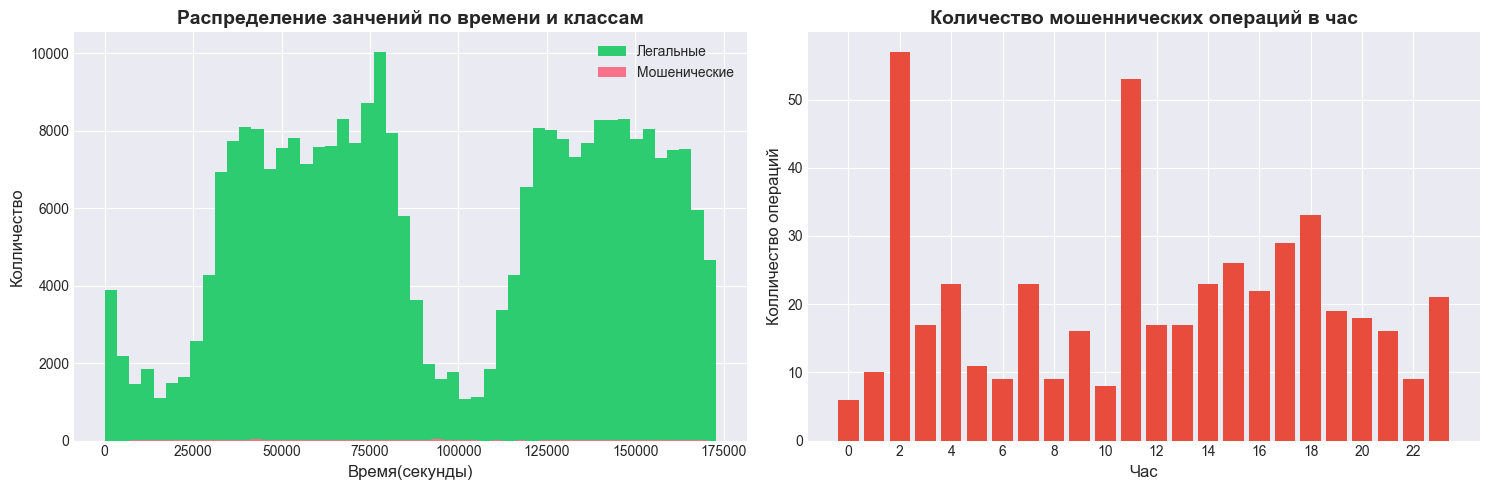

In [5]:
# Распределение по времени

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(credit_data[credit_data['Class'] == 0]['Time'], bins=50, label='Легальные', color="#2ecc71")
axes[0].hist(credit_data[credit_data['Class'] == 1]['Time'], bins=50, label='Мошенические')
axes[0].set_title('Распределение занчений по времени и классам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Время(секунды)', fontsize=12)
axes[0].set_ylabel('Колличество', fontsize=12)
axes[0].legend()

credit_data['Hour'] = ((credit_data['Time'] % 86400) / 3600).astype(int)
fraud_by_hour = credit_data[credit_data['Class'] == 1].groupby('Hour').size()
axes[1].bar(fraud_by_hour.index, fraud_by_hour.values, color='#e74c3c', width=0.8)
axes[1].set_title('Количество мошеннических операций в час', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Час', fontsize=12)
axes[1].set_ylabel('Колличество операций', fontsize=12)
axes[1].set_xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

По графикику видно, что большинство мошенических операций совершаются в ночное время, так же много операций происходит в середине дня. По первому графику видно, что мошенические операции происходят в то время, когда общее колличество операций мало

#### Корреляционный анализ

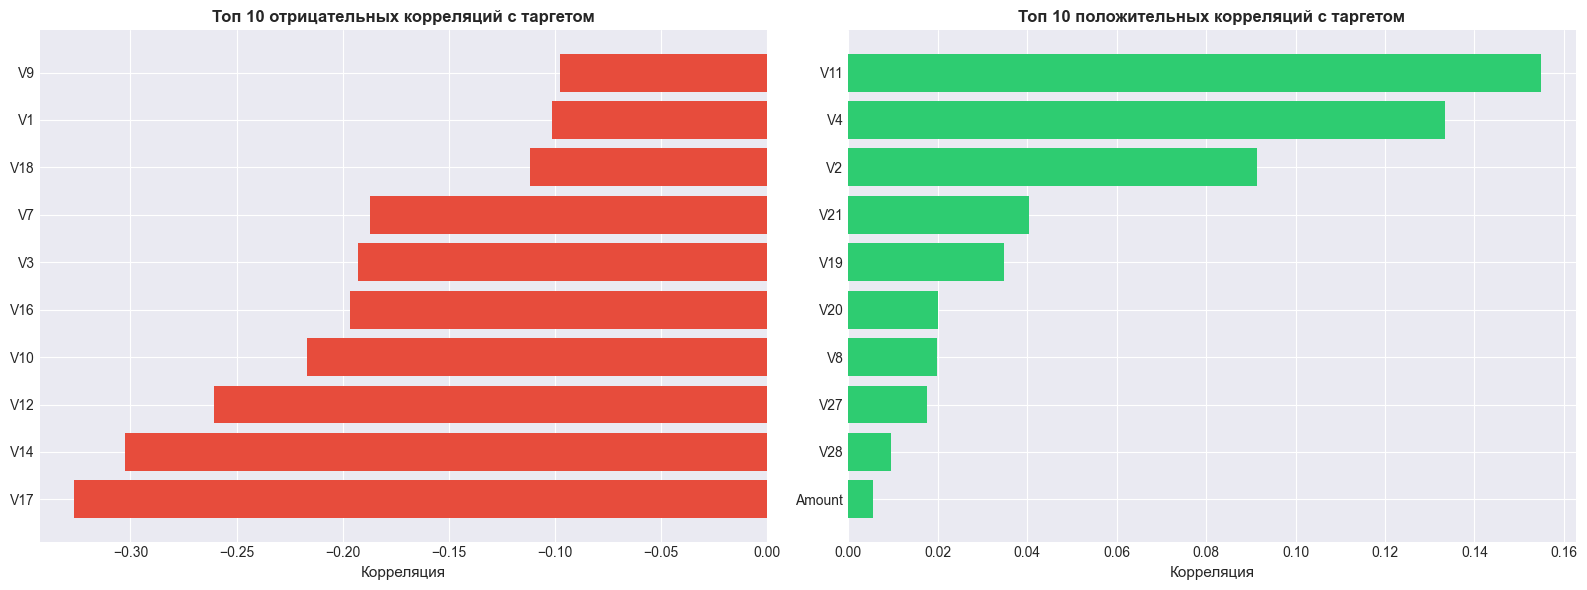

In [5]:
correlations = credit_data.corr()['Class'].drop('Class').sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# топ 10 отрицательных корреляций с таргетом
top_ten_negative = correlations.head(10)
axes[0].barh(top_ten_negative.index, top_ten_negative.values, color='#e74c3c')
axes[0].set_title('Топ 10 отрицательных корреляций с таргетом', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Корреляция', fontsize=11)

# топ 10 положительных корреляций с таргетом
top_ten_positive = correlations.tail(10)
axes[1].barh(top_ten_positive.index, top_ten_positive.values, color='#2ecc71')
axes[1].set_title('Топ 10 положительных корреляций с таргетом', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Корреляция', fontsize=11)

plt.tight_layout()
plt.show()

По графикиам корреляции с таргетом, можно заметить, что большинство признаков в датасете или не имеют корреляции с таргетом или она средняя, поэтому для построения линейных моделей оставим только топ 15 корреляций по модулю

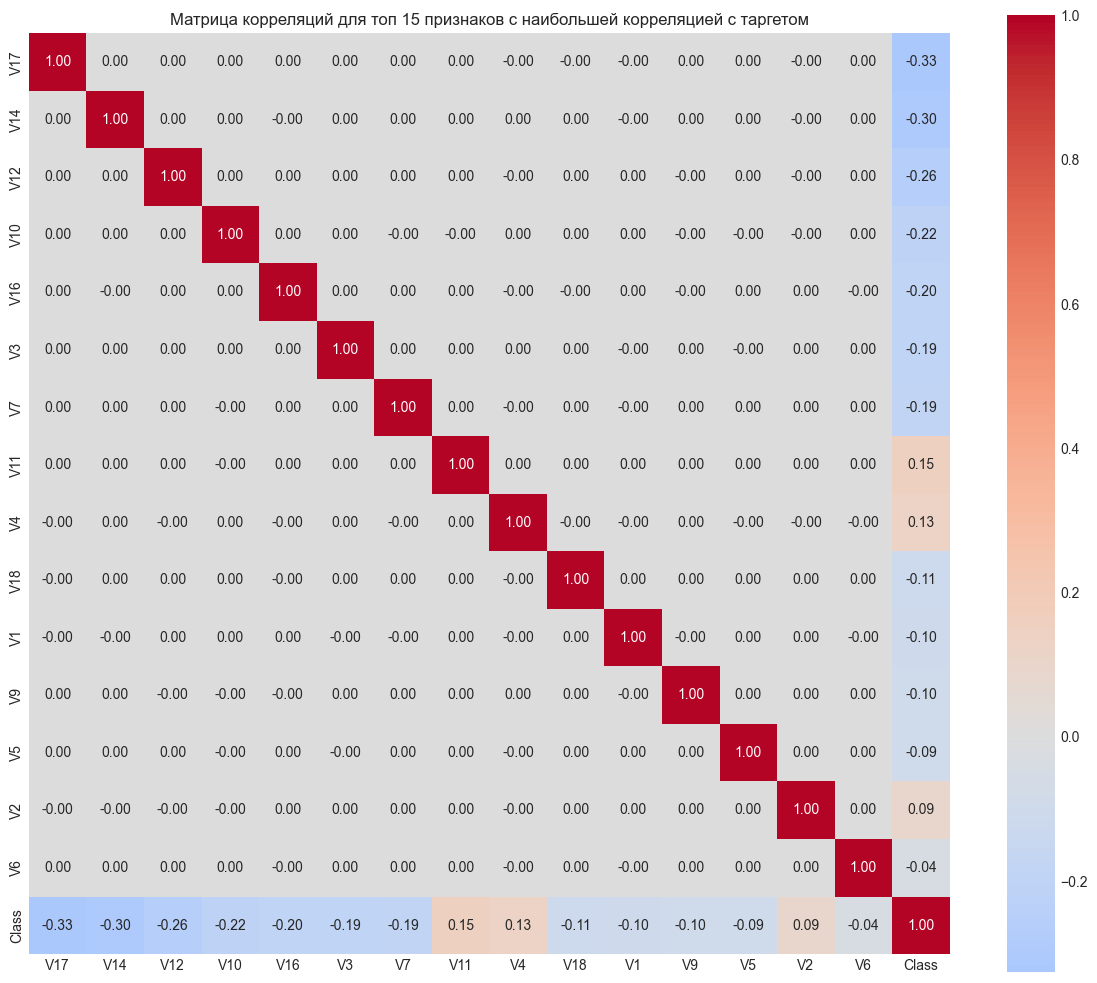

In [6]:
top_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
top_features.append('Class')
plt.figure(figsize=(12, 10))

sns.heatmap(credit_data[top_features].corr(), fmt=".2f", center=0, cmap='coolwarm', annot=True, square=True)
plt.title('Матрица корреляций для топ 15 признаков с наибольшей корреляцией с таргетом')
plt.tight_layout()
plt.show()

Так как признаки являются PCA проекциями изначальных банковских данных, то между признаками нет корреляции и между нимим не возникает мультиколлинеарности

In [7]:
data_preprosessed = credit_data[top_features].copy()

# Удаляем столбец 'Hour' если он есть в top_features
if 'Hour' in data_preprosessed.columns:
    data_preprosessed = data_preprosessed.drop('Hour', axis=1)

X = data_preprosessed.drop('Class', axis=1)
y = data_preprosessed['Class']

print(f"Признаки: {X.shape}")
print(f"Таргет: {y.shape}")
print(f"\nПризнаки: {X.columns.tolist()}")

Признаки: (284807, 15)
Таргет: (284807,)

Признаки: ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V6']


### Подготовка данных и обучение моделей

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mlflow.set_experiment('Fraude | Baseline')

2025/12/17 00:57:47 INFO mlflow.tracking.fluent: Experiment with name 'Fraude | Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1765922267569, experiment_id='1', last_update_time=1765922267569, lifecycle_stage='active', name='Fraude | Baseline', tags={}>

Так как все признаки выбранные для обучения были получены с помощью PCA и уже являются стандартизированными, то дополнительных скейлеров не потребуется

In [9]:
def find_preprosessing_score(model):
    
    best_params = model.best_params_
    best_score = model.best_score_
    
    # Получаем индекс лучшей модели
    best_index = model.best_index_
    results_df = pd.DataFrame(model.cv_results_)
    
    mean_fit_time = results_df['mean_fit_time'].iloc[best_index]
    mean_score_time = results_df['mean_score_time'].iloc[best_index]

    model_stats = {
        'Лучшие параметры': best_params,
        'Время обучения (сек)': round(mean_fit_time, 3),
        'Время предсказания (сек)': round(mean_score_time, 3),
        'Average Precision': round(best_score, 3)
    }

    for key, value in model_stats.items():
        print(f'{key}: {value}')
    return model_stats

Первой моделью будет логистическая регрессия с SMOTE

In [24]:
with mlflow.start_run(run_name='Fraude | Baseline'):

    lr_pipe = ImbLearnPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
        ('log_reg', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ])

    start_l = time.time()
    lr_pipe.fit(X_train, y_train)
    end_l = time.time()

    start_p = time.time()
    y_pred = lr_pipe.predict(X_test)
    end_p = time.time()
    y_pred_proba = lr_pipe.predict_proba(X_test)[:, 1]
    pr_roc = average_precision_score(y_test, y_pred_proba)
    F1 = f1_score(y_test, y_pred)
    mlflow.log_param('model', 'LogReg')
    mlflow.log_param('learning_time', round(end_l - start_l, 3))
    mlflow.log_param('prediction_time', round(end_p - start_p, 3))
    mlflow.log_metric('PR-ROC', round(pr_roc, 3))
    mlflow.log_metric('F1-score', round(F1, 3))
    mlflow.sklearn.log_model(lr_pipe, 'log_reg')

2025/12/17 13:49:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Fraude | Baseline at: http://localhost:5000/#/experiments/1/runs/d1bc70b595204a4dada84b56d2670868
🧪 View experiment at: http://localhost:5000/#/experiments/1


Теперь обучим модель решаюшего дерева со SMOTE для коррекции дисбаланса классов

In [25]:
with mlflow.start_run(run_name='Fraude | Baseline'):

    dtree_pipe = ImbLearnPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('dtree', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

    start_l = time.time()
    dtree_pipe.fit(X_train, y_train)
    end_l = time.time()

    start_p = time.time()
    y_pred = dtree_pipe.predict(X_test)
    end_p = time.time()
    y_pred_proba = lr_pipe.predict_proba(X_test)[:, 1]
    pr_roc = average_precision_score(y_test, y_pred_proba)
    F1 = f1_score(y_test, y_pred)
    mlflow.log_param('model', 'DTree')
    mlflow.log_param('learning_time', round(end_l - start_l, 3))
    mlflow.log_param('prediction_time', round(end_p - start_p, 3))
    mlflow.log_metric('PR-ROC', round(pr_roc, 3))
    mlflow.log_metric('F1-score', round(F1, 3))
    mlflow.sklearn.log_model(dtree_pipe, 'DTree')

2025/12/17 13:50:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Fraude | Baseline at: http://localhost:5000/#/experiments/1/runs/863368692da84fe78db7113d7ec7b534
🧪 View experiment at: http://localhost:5000/#/experiments/1


Теперь обучим случайный лес с class_weight = 'balanced'

In [26]:
with mlflow.start_run(run_name='Fraude | Baseline'):
    rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample')

    start_l = time.time()
    rf.fit(X_train, y_train)
    end_l = time.time()

    start_p = time.time()
    y_pred = rf.predict(X_test)
    end_p = time.time()
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    pr_roc = average_precision_score(y_test, y_pred_proba)
    F1 = f1_score(y_test, y_pred)
    mlflow.log_param('model', 'Random Forest')
    mlflow.log_param('learning_time', round(end_l - start_l, 3))
    mlflow.log_param('prediction_time', round(end_p - start_p, 3))
    mlflow.log_metric('PR-ROC', round(pr_roc, 3))
    mlflow.log_metric('F1-score', round(F1, 3))
    mlflow.sklearn.log_model(rf, 'Random Forest')

2025/12/17 13:52:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Fraude | Baseline at: http://localhost:5000/#/experiments/1/runs/63c11f8756824c00a714c173a17ae1f4
🧪 View experiment at: http://localhost:5000/#/experiments/1



Теперь обучим LightGBM (градиентный бустинг)


In [28]:
with mlflow.start_run(run_name='Fraude | Baseline'):
    lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')

    start_l = time.time()
    lgbm.fit(X_train, y_train)
    end_l = time.time()

    start_p = time.time()
    y_pred = lgbm.predict(X_test)
    end_p = time.time()
    y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
    pr_roc = average_precision_score(y_test, y_pred_proba)
    F1 = f1_score(y_test, y_pred)
    mlflow.log_param('model', 'LightGBM')
    mlflow.log_param('learning_time', round(end_l - start_l, 3))
    mlflow.log_param('prediction_time', round(end_p - start_p, 3))
    mlflow.log_metric('PR-ROC', round(pr_roc, 3))
    mlflow.log_metric('F1-score', round(F1, 3))
    mlflow.sklearn.log_model(
    lgbm,
    artifact_path="model",
    registered_model_name="LGBM"
        )
    mlflow.set_tag("stage", "baseline")

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


2025/12/17 13:56:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'LGBM' already exists. Creating a new version of this model...
2025/12/17 13:56:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM, version 2
Created version '2' of model 'LGBM'.


🏃 View run Fraude | Baseline at: http://localhost:5000/#/experiments/1/runs/dbe3626599a34bd19318c9ef5406b659
🧪 View experiment at: http://localhost:5000/#/experiments/1


итоговой моделью я выбрал LGBMClassifier, так как она на втором месте по точности, и обчуется быстрее точной модели в 10 раз

сделаем тюнинг модели с помощью подбора гиперпараметров

In [39]:
best_score = 0
best_model = None
best_params = None


with mlflow.start_run(run_name='Fraude | LGBM Tune'):
    lgbm_params_grid = {
    'num_leaves': [20, 31, 50, 100],
    'max_depth': [-1, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
    }

    lgbm_search = RandomizedSearchCV(
        LGBMClassifier(),
        lgbm_params_grid,
        cv=cv,
        scoring='average_precision',
        verbose=2,
        n_jobs=-1,
        n_iter=50
    )

    lgbm_search.fit(X_train, y_train)
    best_model = lgbm_search.best_estimator_
    best_params = lgbm_search.best_params_
    best_score = lgbm_search.best_score_

    y_pred = lgbm_search.predict(X_test)
    y_pred_proba = lgbm_search.predict_proba(X_test)[:, 1]
    F1 = f1_score(y_test, y_pred)
    mlflow.log_param('model', 'LightGBM Tuned')
    mlflow.log_metric('PR-ROC', best_score)
    mlflow.log_metric('F1-score', round(F1, 3))
    mlflow.sklearn.log_model(
    best_model,
    artifact_path="model",
    registered_model_name="LGBM"
        )
    mlflow.set_tag("stage", "tuning")



Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025/12/17 15:09:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'LGBM' already exists. Creating a new version of this model...
2025/12/17 15:09:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM, version 4


🏃 View run Fraude | LGBM Tune at: http://localhost:5000/#/experiments/1/runs/10865b079b77483383c531f67a6adc12
🧪 View experiment at: http://localhost:5000/#/experiments/1


Created version '4' of model 'LGBM'.


Проверим итоговую модель на тестовых данных и вычислим занчения некоторых метрик

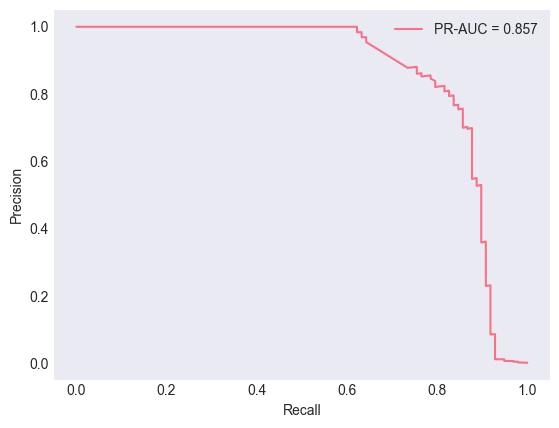

In [41]:
y_scores = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

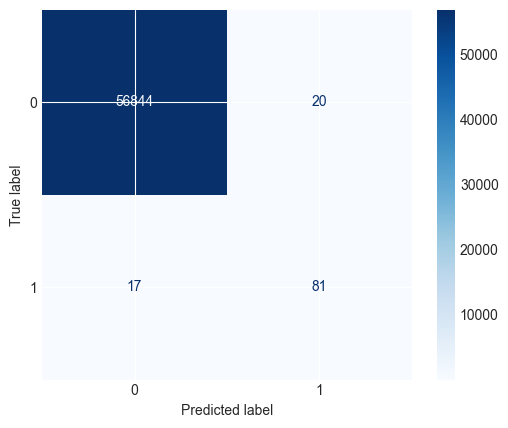

In [42]:
threshold = 0.3  # пример — не 0.5!
y_pred = (y_scores >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.show()

In [43]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

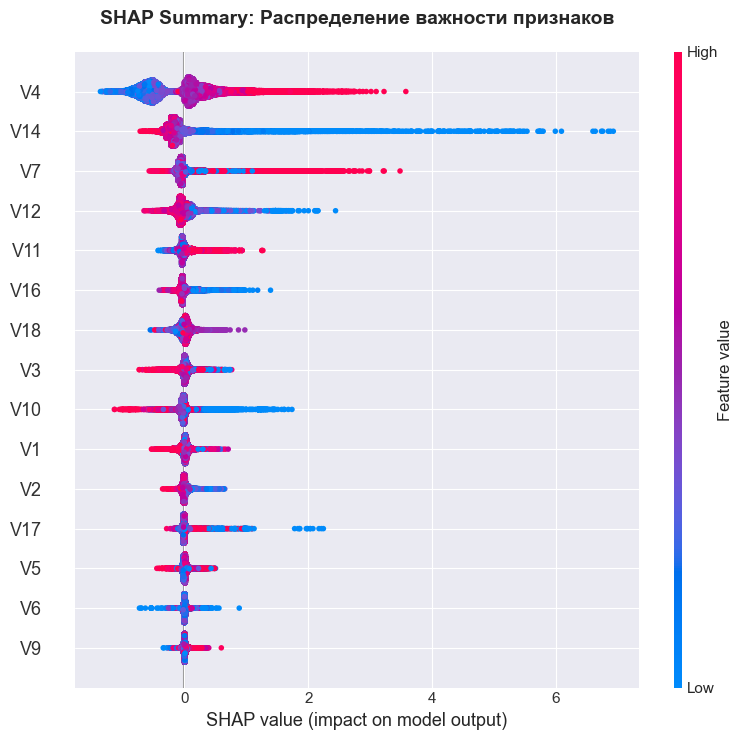

In [44]:
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary: Распределение важности признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


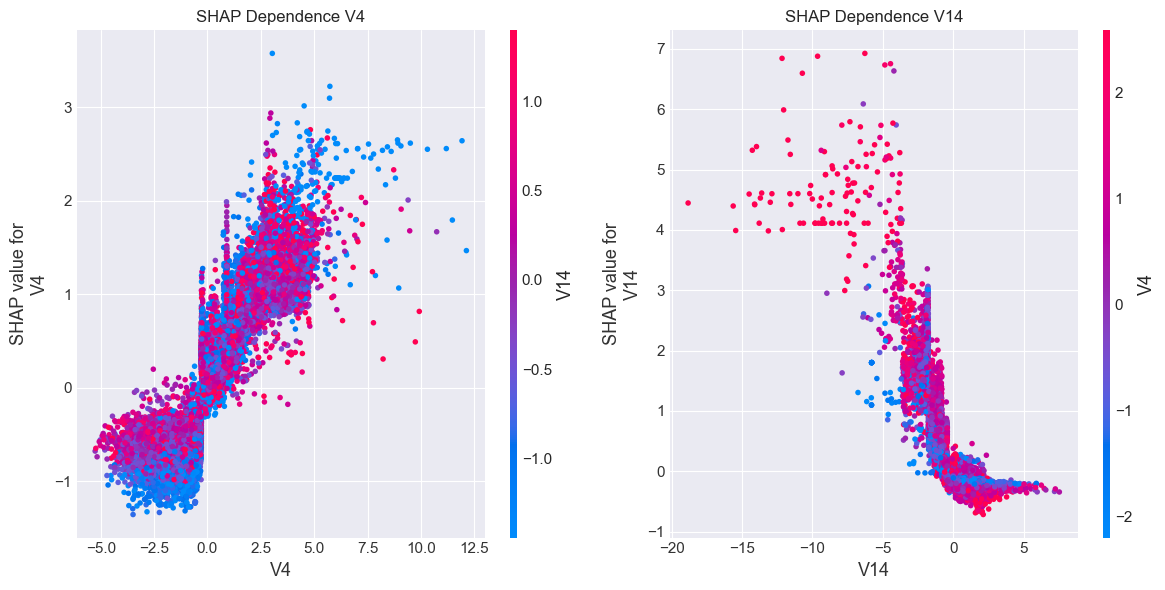

In [45]:

# shap_values может быть списком (по классам) — возьмём вклад положительного класса, если нужно
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dependence для V4
shap.dependence_plot('V4', sv, X_test, ax=axes[0], show=False)
axes[0].set_title('SHAP Dependence V4')

# Dependence для V14
shap.dependence_plot('V14', sv, X_test, ax=axes[1], show=False)
axes[1].set_title('SHAP Dependence V14')

plt.tight_layout()
plt.show()